In [1]:
import glob
import numpy as np
import pandas as pd
import h5py 

from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker

### loading data

In [2]:
file = pd.read_csv('../output/scores/simulation/scores/fripscore_hres.csv')

In [3]:
convertor = 21.875 * 60/500 #to convert from lattice based to seconds

file[' clife']= np.round(file[' clife']*convertor)
file[' cof']= np.round(file[' cof']*convertor)
file_100 = file[file['sep']==100.0]

unique_life = np.unique(file['lifetime'])
unique_vel = np.unique(file[' velocity'])
unique_clife = np.unique(file[' clife'])
unique_cof = np.unique(file[' cof'])
unique_clife
clife_list = [clife_val for clife_val in unique_clife if clife_val<6000]
clife_list = [26.0, 52.0, 79.0, 105.0, 131.0, 262.0, 525.0, 1050.0, 1312.0, 2625.0, 5250.0]
cof_list = [np.round(cof_val) for cof_val in unique_cof if cof_val<=500]
cof_list = [3, 5, 10, 16,  21.0, 24.0, 34.0,  45.0, 60.0, 87.0,  131.0, 197.0, 315.0,  449]

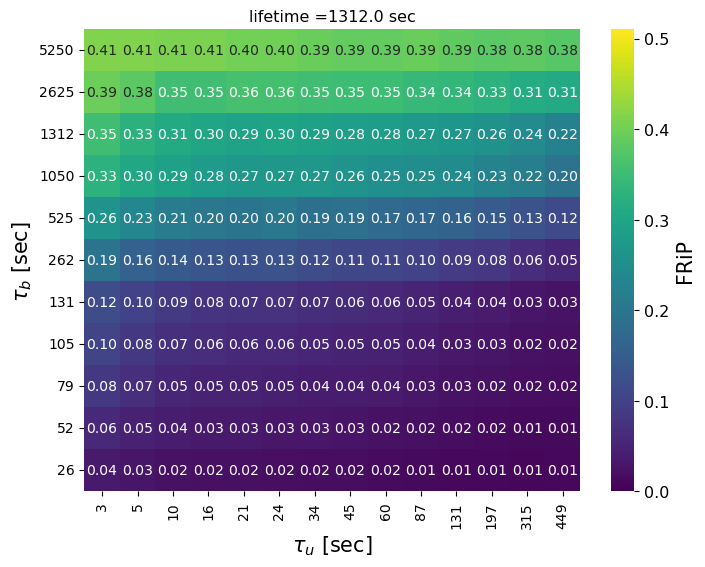

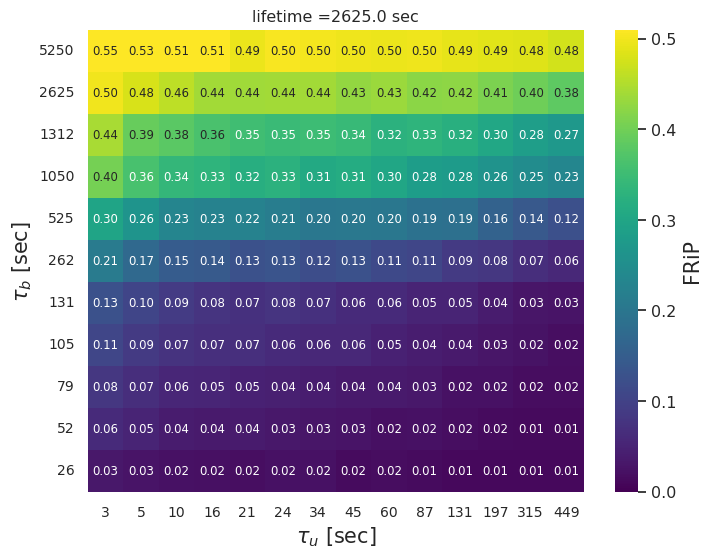

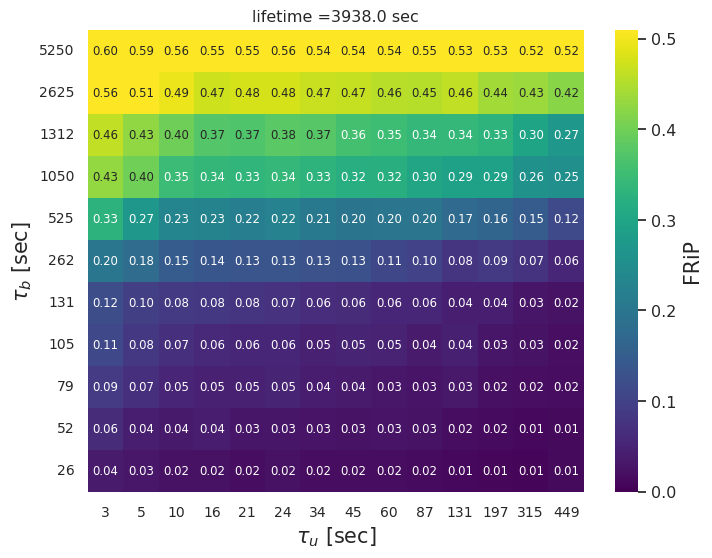

In [4]:
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file_100.query('lifetime == @life and ` velocity` == @vel')[[' clife',' cof',' fripscore']]
        new_file = new_file[new_file[' clife'].isin(clife_list)]
        new_file = new_file[new_file[' cof'].isin(cof_list)]
        new_file_filtered = new_file
        heatmap_data = new_file_filtered.pivot(' clife', ' cof', ' fripscore')
        
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f', vmin=0.0,vmax=0.51, cbar_kws={'label': 'Frip score'} )
        sns.set(font_scale=0.701)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.5)
        cbar.set_label('FRiP', fontsize=14.75)
        # Customize 
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        plt.xlabel(r'$\tau_u$ [sec]', fontsize = 15)
        plt.xticks(fontsize =10)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =15)
        plt.yticks(fontsize = 10, rotation=0)
        plt.title('lifetime =%s sec'%(np.round(life*convertor)), fontsize = 11.5)
        plt.gca().invert_yaxis()
        plt.savefig('../output/figures/fripsweep_for_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

In [5]:
more_file_filtered = new_file_filtered
more_file_filtered[' occup'] = more_file_filtered[' clife']/(more_file_filtered[' clife']+more_file_filtered[' cof'])
more_file_filtered = more_file_filtered[[' clife',' cof',' occup']]

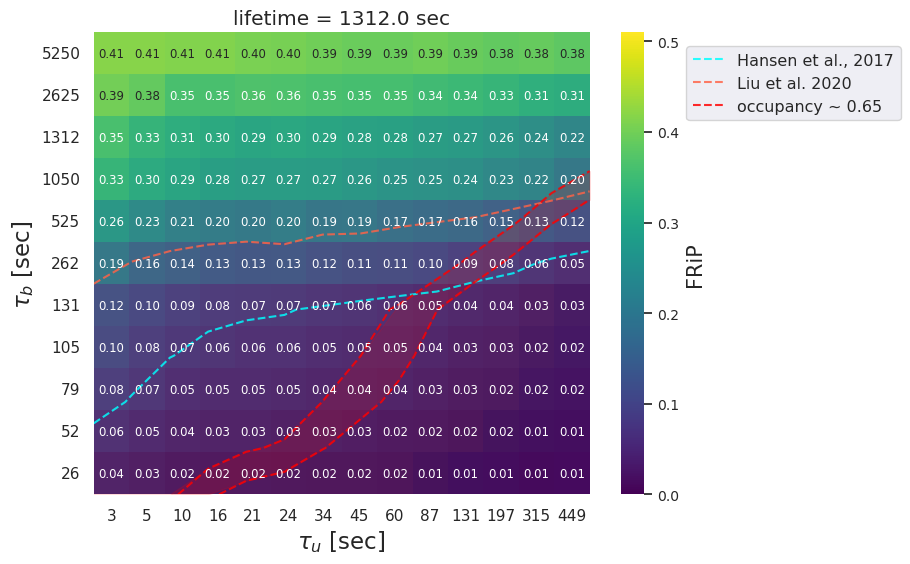

In [6]:
unique_life = [500]
unique_vel = [1]
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file_100.query('lifetime == @life and ` velocity` == @vel')[[' clife', ' cof', ' fripscore']]
        new_file = new_file[new_file[' clife'].isin(clife_list)]
        new_file = new_file[new_file[' cof'].isin(cof_list)]
        new_file_filtered = new_file
        heatmap_data = new_file_filtered.pivot(' clife', ' cof', ' fripscore')
        
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f', vmin=0.0, vmax=0.51, cbar_kws={'label': 'Frip score'})
        sns.set(font_scale=0.691)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('FRiP', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        cline_num = 14
        coline_num = 11
        cntr1 = im.contour(np.linspace(0, cline_num, cline_num * smooth_scale),
                           np.linspace(0, coline_num, coline_num * smooth_scale),
                           heatmap_data.to_numpy(), levels=[0.071], colors='cyan', linestyles='dashed', alpha=0.83)
        
        cntr3 = im.contour(np.linspace(0, cline_num, cline_num * smooth_scale),
                           np.linspace(0, coline_num, coline_num * smooth_scale),
                           heatmap_data.to_numpy(), levels=[0.16], colors='tomato', linestyles='dashed', alpha=0.83)

        hansen_line, = plt.plot([], [], color='cyan', linestyle='dashed', alpha=0.83, label='Hansen et al., 2017')
        Liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al. 2020')
        
        ### occupancy exp det
        new_heatmap_data = more_file_filtered.pivot(' clife', ' cof', ' occup')
        
        smooth_scale = 1
        z = ndimage.zoom(new_heatmap_data.to_numpy(), smooth_scale)
        
        new_im = sns.heatmap(new_heatmap_data, annot=False, cmap='viridis', alpha=0.05, vmin=0.0, vmax=0.3, cbar=None)

        cntr1 = new_im.contour(np.linspace(0, cline_num, cline_num * smooth_scale),
                               np.linspace(0, coline_num, coline_num * smooth_scale),
                               new_heatmap_data.to_numpy(), levels=[0.6], colors='red', linestyles='dashed', alpha=0.83)
        
        cntr3 = new_im.contour(np.linspace(0, cline_num, cline_num * smooth_scale),
                               np.linspace(0, coline_num, coline_num * smooth_scale),
                               new_heatmap_data.to_numpy(), levels=[0.7], colors='red', linestyles='dashed', alpha=0.83)
        occupancy_line, = plt.plot([], [], color='red', linestyle='dashed', alpha=0.83, label='occupancy ~ 0.65')
        
        x_cntr1 = np.linspace(0, cline_num, cline_num * smooth_scale)
        y_cntr1 = np.interp(x_cntr1, cntr1.collections[0].get_paths()[0].vertices[:, 0],
                            cntr1.collections[0].get_paths()[0].vertices[:, 1])
        
        x_cntr3 = np.linspace(0, cline_num, cline_num * smooth_scale)
        y_cntr3 = np.interp(x_cntr3, cntr3.collections[0].get_paths()[0].vertices[:, 0],
                            cntr3.collections[0].get_paths()[0].vertices[:, 1])
        
        plt.fill_between(x_cntr1, y_cntr1, y_cntr3, color='red', alpha=0.15)
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])        
        plt.xlabel(r'$\tau_u$ [sec]', fontsize=16.5)
        plt.xticks(fontsize=11)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize=16.5)
        plt.yticks(fontsize=11, rotation=0)
        plt.title('lifetime = %s sec' % (np.round(life * convertor)), fontsize=14.5)
        plt.gca().invert_yaxis()
        
        # Add legend
        plt.legend(handles=[hansen_line, Liu_line, occupancy_line], loc=(1.195,0.81), fontsize =11.5)
        
        plt.savefig('../output/figures/fripsweep_for_%s_%s_estimated_exp.pdf' % (life, vel), transparent=True, bbox_inches='tight')
        plt.show()


### heat maps of Frip and occupancy rate

In [7]:
file = pd.read_csv('../output/scores/simulation/scores/fripscore_hres.csv')
file ['occupancy']=(file[' clife']/(file[' clife']+file[' cof'])).round(2)
file = file[file['occupancy']<=0.915]

In [8]:
aimed_occupancy = [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

occup_list = []
for occups in np.unique(file['occupancy']):
    for occup_a in aimed_occupancy:
        if np.abs(occups-occup_a) <= 0.03:
            occup_list.append(occups)

In [9]:
new_file = file[file['occupancy'].isin(occup_list)]

In [10]:
new_file['occupancy']=np.round(new_file['occupancy'],1)

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


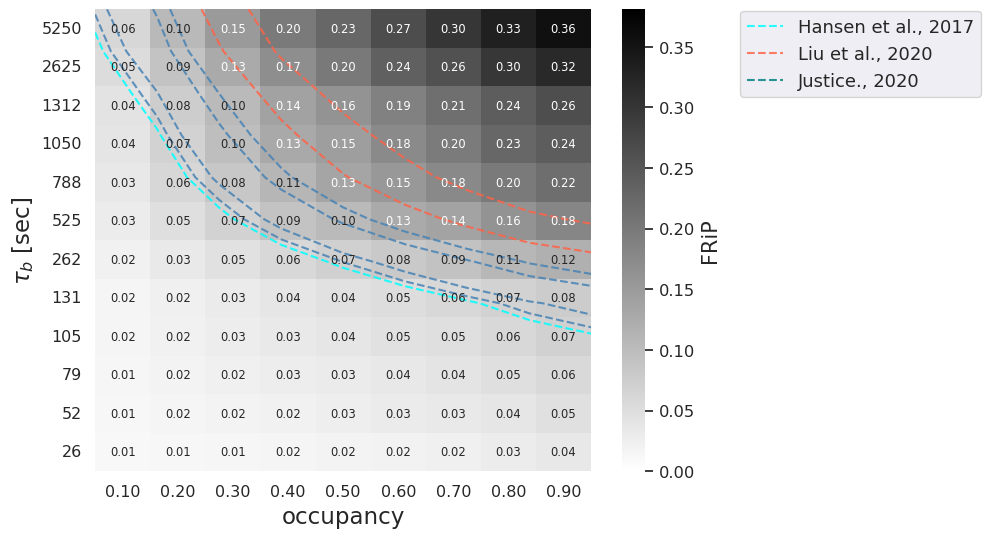

In [11]:
list_life, list_vel = [500], [1]

numline_c = 12
numline_o =9
for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = new_file.query('lifetime == @life and ` velocity` == @vel')[[' clife','occupancy',' fripscore']]
    
        dtaframe = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
        new_file_filtered_unique = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
        # Remove any NaN values
        new_file_filtered_unique = new_file_filtered_unique.dropna()
        
        # Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
        dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()
        convertor = 21.875 * 60/500
        dtaframe_grouped [' clife']= (dtaframe_grouped[' clife']*convertor).round()
        dtaframe_grouped=dtaframe_grouped[dtaframe_grouped[' clife']<=6000]
        heatmap_data = dtaframe_grouped.pivot(' clife', 'occupancy', ' fripscore')
                
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='gray_r', fmt = '0.2f',vmin=0.0,vmax=0.381, cbar_kws={'label': 'Frip score'} )
        sns.set(font_scale=0.831)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('FRiP', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        smooth_scale = 1
        d = gaussian_filter(heatmap_data.to_numpy(), sigma=1)
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        cntr1 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.071], colors='cyan', linestyles='dashed', alpha=0.85)
        
        cntr3 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.13], colors='tomato', linestyles='dashed', alpha=0.85)
        cntr4 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.16], colors='tomato', linestyles='dashed', alpha=0.85)
        cntr5 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.11], colors='steelblue', linestyles='dashed', alpha=0.85)
        cntr6 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.1], colors='steelblue', linestyles='dashed', alpha=0.85)
        cntr7 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.074], colors='steelblue', linestyles='dashed', alpha=0.85)
        cntr7 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           d, levels=[0.08], colors='steelblue', linestyles='dashed', alpha=0.85)
        # Add legend manually for the contours
        hansen_line, = plt.plot([], [], color='cyan', linestyle='dashed', alpha=0.83, label='Hansen et al., 2017')
        Liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al., 2020')
        justice_line, = plt.plot([], [], color='teal', linestyle='dashed', alpha=0.83, label='Justice., 2020')
        
        im.set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        ytick_labels = [int(float(t.get_text())) for t in im.get_yticklabels()]
        plt.xlabel(r'occupancy', fontsize = 16.5)
        plt.xticks(fontsize =11.5, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11.5, rotation = 0)
        # Add legend
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        plt.legend(handles=[hansen_line, Liu_line, justice_line], loc=(1.3,0.81), fontsize =12.95)
        plt.gca().invert_yaxis()
        plt.savefig('../output/figures/fripsweep_for_occupancy_%s_%s_color_a.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

In [12]:
aimed_occupancy = [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

occup_list = []
for occups in np.unique(file['occupancy']):
    for occup_a in aimed_occupancy:
        if np.abs(occups-occup_a) <= 0.0115:
            occup_list.append(occups)

In [13]:
file = pd.read_csv('../output/scores/simulation/scores/fripscore_hres.csv')

file ['occupancy']=(file[' clife']/(file[' clife']+file[' cof'])).round(2)
file
new_file = file[file['occupancy'].isin(occup_list)]
new_file['occupancy']=np.round(new_file['occupancy'],1)

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
list_occup = np.unique(new_file['occupancy'])

In [15]:
new_file_filtered_unique = new_file.query('lifetime == @life and ` velocity` == @vel')[[' clife','occupancy',' fripscore']]
        
new_file_filtered_unique = new_file_filtered_unique.dropna()

# Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()

In [16]:
num_plot =7
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()
sns.reset_defaults()

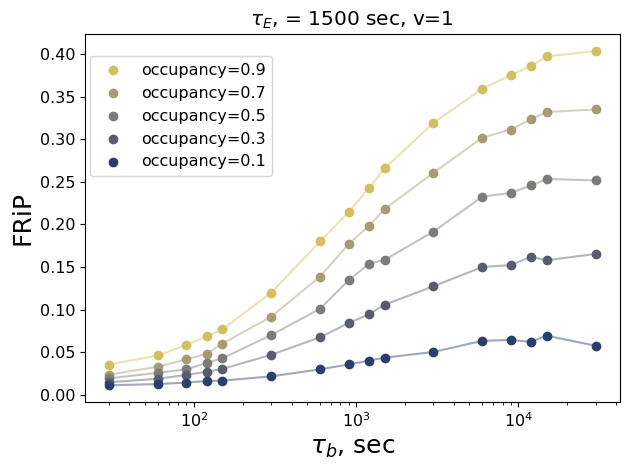

In [17]:
lifes, vels = [500] , [1]

#occupancy=file[' occupancy']
list_occup = [ 0.9,  0.7,  0.5, 0.3, 0.1]
convertor = 21.875 * 60 / 500

i=1
sns.reset_defaults()

for life in lifes:
    for vel in vels:
        for occup in list_occup[:]:
            new_file_filtered_unique = new_file.query('lifetime == @life and ` velocity` == @vel')[[' clife','occupancy',' fripscore']]
        
            new_file_filtered_unique = new_file_filtered_unique.dropna()
            
            # Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
            dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()
            convertor = 3
            dtaframe_grouped [' clife']= dtaframe_grouped[' clife']*convertor
            dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['occupancy']==occup]
            dtaframe_grouped = dtaframe_grouped[[' clife', ' fripscore']]
            new_file_filtered = dtaframe_grouped.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values(' clife')
            new_clife = new_file_filtered[' clife']
            frip_score = new_file_filtered[' fripscore']
            plt.scatter(new_clife[:], frip_score[:], color=colors[i],label=r'occupancy=%s'%(occup))
            plt.plot(new_clife[:], frip_score[:], color=colors[i],alpha = 0.45)
            i+=1

life_w = 500*convertor
delta = 300*convertor
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (0.01,0.615))
plt.ylabel('FRiP',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
plt.savefig('../output/figures/frip_for_tau.pdf',transparent=True)

plt.show()
        

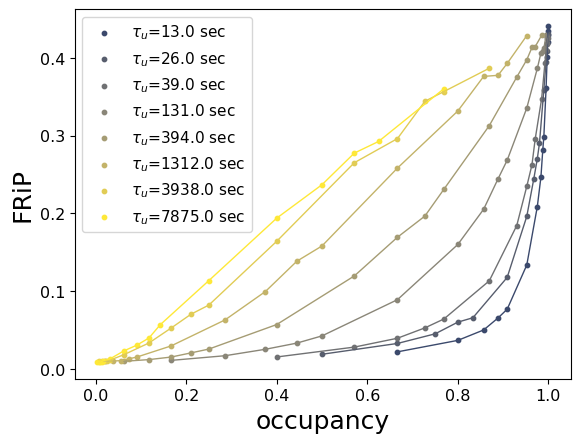

In [18]:
lifes, vels = [500] , [1]


i=1
num_plot = 10
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

file = pd.read_csv('../output/scores/simulation/scores/fripscore_hres.csv')
convertor = 21.875 * 60 / 500
file = file[file['sep']==100]
cof_val = 10
list_cof =[5, 10,  15, 50, 150, 500,1500, 3000]
for cof_val in list_cof:
    for life in lifes:
        for vel in vels:
            i+=1
            new_file = file.query('lifetime == @life and ` velocity` == @vel and ` cof` == @cof_val')[[' clife',' cof', ' fripscore']]
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values(' clife')
            new_clife = new_file_filtered[' clife']
            frip_score = new_file_filtered[' fripscore']
            plt.scatter(new_clife/(new_clife+cof_val), frip_score, label = r'$\tau_u$=%s sec'%(np.round(cof_val*convertor)),linewidth=1,s=10, color = colors[i])
            plt.plot(new_clife/(new_clife+cof_val), frip_score, linewidth=1, color = colors[i])


file = pd.read_csv('../output/scores/simulation/scores/fripscore_static.csv')
frip_score = file[' fripscore']
cof_val = 1
clife_val = 10
for life in lifes:
    for vel in vels:
        new_file_stat = file.query('lifetime == @life and ` velocity` == @vel and ` clife` == @clife_val and ` cof` == @cof_val')[[' face', ' fripscore']]
        new_file_filtered = new_file_stat.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values(' face')
        new_face = new_file_filtered[' face']
        frip_score = new_file_filtered[' fripscore']

file = pd.read_csv('../output/scores/simulation/scores/fripscore_static_pause_with_number.csv')
file = file[(file['lifetime']==500)&(file[' velocity']==1)&(file[' separation']==100)]
seps = np.unique(file[' face'])
frip_score = file[' fripscore']
cof_val = 1
clife_val = 10
for life in lifes:
    for vel in vels:
        new_file_stat = file[[' face', ' fripscore']]
        new_file_filtered = new_file_stat.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values(' face')
        new_face = new_file_filtered[' face']
        frip_score = new_file_filtered[' fripscore']
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize=11)

plt.ylabel('FRiP',fontsize = 18)
plt.xlabel(r'occupancy', fontsize = 18)
plt.savefig('../output/figures/frip_for_occup_tau_u.pdf',bbox_inches='tight')
plt.show()